# DeXtrusion network training 

This notebook performs deXtrusion network training starting from scratch. It uses labelled data (movies with ImageJ ROI files of events)

## Setting up the parameters

The training movies should be in a unique folder, associated with the ImageJ ROI files of the events to detect. The name of the ROI files should be the name of the movie+name of the event as given in the 'catnames' parameter. 
For example, if the movie is named `mymovie.tif`, it should be associated with the ROI files `mymovie_cell_death.zip`, `mymovie_cell_sop.zip` and so on. 
Control ROI (with no event) don't have to be provided, they will be automatically generated by looking at spots where there is no other ROIs. However, if you want to enforce some position as being control windows (for example to reduce the false positive rates), you can add them in a file `mymovie_nothing.zip` and set the paramter `add_nothing_windows` to a positive value.

In [ ]:
from dextrusion import MovieGeneratorFromROI as gen
from dextrusion.DeXtrusion import DeXtrusion
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Training data parameters
path = "/Users/yuyangsmacbook/Desktop/annotation_400+400+400"  ## folder where the training data are 
catnames = ["", "_cell_death.zip", "_cell_division"]  ## names of the events to detect (1st one should be no event window)
ncat = len(catnames)
cell_diameter = 25      ## typical size of a cell diameter in the training dataset (usefull to rescale movies after training)
extrusion_duration = 4.5   ## typical duration of a cell extrusion (or other event to use as temporal reference)

## Network DeXNet parameters
## half size of the sliding window
half_size = (22, 22)  
## nb frames before and after the event in the sliding window
nframes = (5, 10)     
## if 0, no data taken, 1, no augmentation, >1 augmentation (validation non independant)
naug = 3 
## add ROIs from file XX_nothing.zip and augment them n times (to reduce FP)
add_nothing_windows = 2  
## training batch size
batchSize = 50        
## training number of iterations
nepochs = 100          
 ## ratio of rois used for validation vs training
validation_ratio = 0.2 
## network size (initial number of features)
nfilters = 8  
## where to save the resulting network and name
modelpath = '../deXNets/notum_newtraining_0906/'  

talkative = True  ## print info messages

## Load training and validation data

In [12]:
## generates the training windows
train = gen.MovieGeneratorFromROI(
                 data_path = path,
                 batch_size=batchSize,
                 frame_shape=nframes,
                 win_halfsize = half_size,
                 val_ratio=validation_ratio,
                 balance=True,
                 ncat=ncat,
                 cat_names = catnames,
                 naug=naug,
                 augment_withnoise=True,
                 add_nothing_windows =  add_nothing_windows,
                 verbose=0)

if talkative:
    print("Training size: "+str(train.__len__()*batchSize))
    print("Nb of batchs: "+str(train.__len__()))

## generates the validation windows
valid = train.get_validation_generator()
if talkative:
    print("Validation size: "+str(valid.__len__()*batchSize))

Training size: 2400
Nb of batchs: 48
Validation size: 600


## Visualize an example of a window to check

Roi category: [0. 1.] -> _cell_death.zip


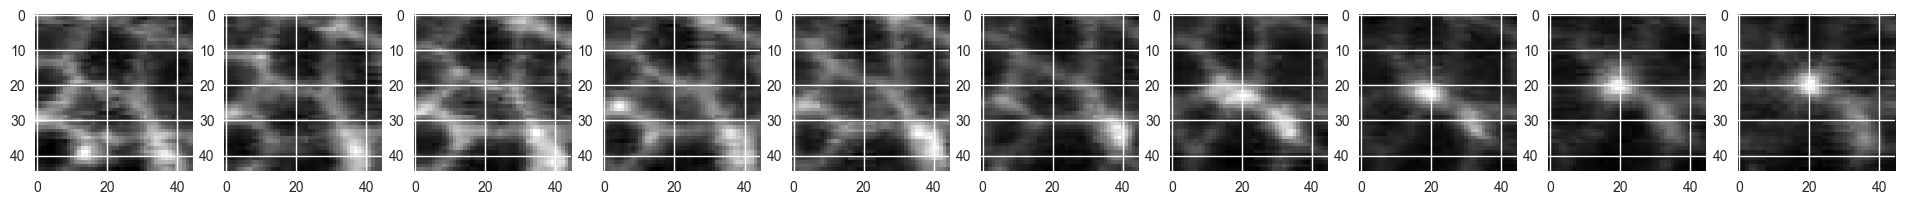

In [13]:
## visualize sample "samplen" of batch "batchn" of training data
batchn = 3
samplen = 10

# get the corresponding window
vid = train.__getitem__(batchn)
roitype = vid[1][samplen]
event = catnames[np.argmax(roitype)]

print("Roi category: "+str(roitype)+" -> "+event)
vid = vid[0][samplen]
fig, ax = plt.subplots(1,np.sum(nframes), figsize=(24,6))
for i in range(0,np.sum(nframes)):
    ax[i].imshow(vid[i*1,:,:], cmap='gray')

## Initialize, train and save the neural network

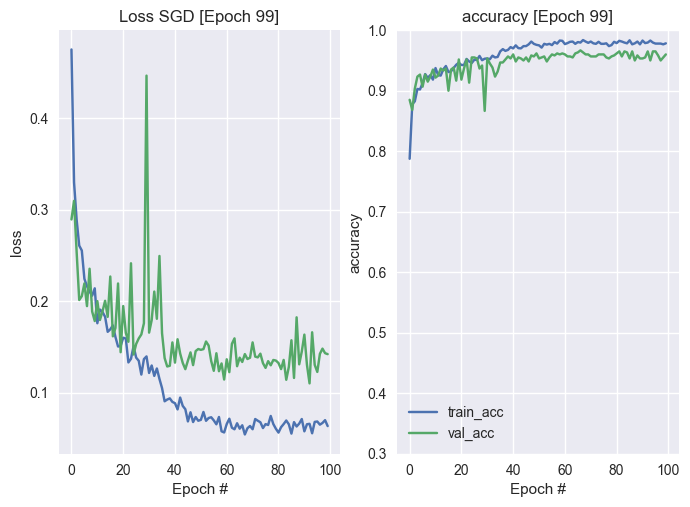

48/48 [==============================] - 6s 116ms/step - loss: 0.0633 - acc: 0.9783 - val_loss: 0.1420 - val_acc: 0.9600 - lr: 1.0000e-05
----- Training in 9.141986536979676 minutes ----
INFO:tensorflow:Assets written to: ../deXNets/notum_newtraining_ND_anw2/assets


INFO:tensorflow:Assets written to: ../deXNets/notum_newtraining_ND_anw2/assets


In [14]:
if talkative:
    print("One image size "+str(np.sum(nframes))+", "+str(half_size[0]*2+1)+", "+str(half_size[1]*2+1))

## initialize
dexter = DeXtrusion(verbose=talkative)
## set the paramters that were defined above
dexter.set_parameters( nframes=nframes, 
                       half_size=half_size, 
                       ncat=ncat, 
                       catnames=catnames, 
                       nb_filters=nfilters, 
                       batch_size=batchSize, 
                       model_path=modelpath,
                       cell_diameter = cell_diameter,
                       extrusion_duration = extrusion_duration )

## build the network architecture (can be changed in the src file Network.py) 
dexter.initialize_model(nframes=nframes, half_size=half_size, ncat=ncat, nb_filters=nfilters, batch_size=batchSize, model_path=modelpath)

## train
dexter.train_model(train_generator=train, validation_generator=valid, epochs=nepochs, save=True)

## clean and save configuration
## remove the created files used for the training and validation
train.clean_tempdir()  
## add the parameter values to the config file of the model, usefull to reload it later
dexter.add_configuration_info(nepochs=nepochs, naug=naug, add_nothing_windows=add_nothing_windows, path=path)  

## Test on new data, windows

In [ ]:
## folder where the test movies (with the ROI files) are to test the performance. The format should be the same as the training data
test_path = "../../data/notum_WT/test/"  

# generate the test windows
test = gen.MovieGeneratorFromROI(
                 data_path = test_path,
                 batch_size=batchSize,
                 frame_shape = nframes,
                 win_halfsize = half_size,
                 val_ratio=0,
                 balance=False,
                 ncat=ncat,
                 cat_names = catnames,
                 naug=1,
                 augment_withnoise=False,
                 add_nothing_windows = 1,
                 verbose = talkative )

# evaluate the prediction and print the confusion matrix
dexter.evaluate_model_prediction(test)
## remove the created files used for the training and validation
test.clean_tempdir()  